In [1]:
import pmdarima as pmd
import numpy as np
import pandas as pd
import pickle
import boto3
from io import StringIO
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from pandas.plotting import autocorrelation_plot

from utils_functions import *

In [2]:
file_key = 'data-transformed/run-1731935541465-part-r-00000.csv'
mta_subway_df = read_s3_csv_to_dataframe(file_key)

In [3]:
mta_subway_df.head()

station_complex_id                station_complex   latitude  longitude  \
0                 155  Cathedral Pkwy (110 St) (C,B)  40.800602  -73.95816   
1                 231                 Grand St (B,D)  40.718266  -73.99375   
2                 299                 Dyckman St (1)  40.860530  -73.92554   
3                 321                      18 St (1)  40.741040  -73.99787   
4                 395                     103 St (6)  40.790600  -73.94748   

                  georeference  number_of_riderships created_date  year_period  
0  POINT (-73.95816 40.800602)                2398.0   2023-01-01         2023  
1  POINT (-73.99375 40.718266)               11274.0   2023-01-01         2023  
2   POINT (-73.92554 40.86053)                1940.0   2023-01-01         2023  
3   POINT (-73.99787 40.74104)                1955.0   2023-01-01         2023  
4    POINT (-73.94748 40.7906)                2834.0   2023-01-01         2023

- First and Last date

In [4]:
print(mta_subway_df['created_date'].min(), "and" ,mta_subway_df['created_date'].max())

2023-01-01 00:00:00 and 2024-09-30 00:00:00


- Average of riderships by station

In [5]:
riderships_by_stations = mta_subway_df.groupby(['station_complex_id', 'station_complex'])[['number_of_riderships']].mean().reset_index().sort_values(by='number_of_riderships', ascending=False)
stations_top_10 = riderships_by_stations.head(10)
stations_top_20 = riderships_by_stations.head(20)

In [6]:
stations_top_20

station_complex_id                                    station_complex  \
109                 611   Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)   
108                 610                    Grand Central-42 St (S,4,5,6,7)   
106                 607                  34 St-Herald Sq (B,D,F,M,N,Q,R,W)   
104                 602                   14 St-Union Sq (L,N,Q,R,W,4,5,6)   
119                 628                        Fulton St (A,C,J,Z,2,3,4,5)   
31                  164                         34 St-Penn Station (A,C,E)   
112                 614                  59 St-Columbus Circle (A,B,C,D,1)   
66                  318                         34 St-Penn Station (1,2,3)   
117                 624  Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...   
111                 613                 Lexington Av (N,R,W)/59 St (4,5,6)   
110                 612                 Lexington Av-53 St (E,M)/51 St (6)   
40                  225                47-50 Sts-Rockefeller Ctr (B,D,F,M)   
113                 618                             14 St (A,C,E)/8 Av (L)   
107                 609                       Bryant Pk (B,D,F,M)/5 Av (7)   
103                 601                         14 St (F,M,1,2,3)/6 Av (L)   
83                  397                                      86 St (4,5,6)   
116                 623                           Canal St (J,N,Q,R,W,Z,6)   
33                  167                     W 4 St-Wash Sq (A,C,E,B,D,F,M)   
114                 619    Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)   
63                  313                                      72 St (1,2,3)   

     number_of_riderships  
109         119525.450704  
108          86682.890454  
106          65090.749609  
104          59509.798122  
119          49945.593114  
31           47826.935837  
112          43966.830986  
66           42592.815336  
117          34418.302034  
111          32054.583725  
110          31856.350548  
40           31326.068858  
113          30552.433490  
107          30026.452269  
103          29828.107981  
83           29106.773083  
116          28915.586854  
33           27863.768388  
114          25510.303599  
63           25216.215962

We can see that Times Square - 42 has an average of 120K riderships per day.

In [7]:
stations_top_10_id = list(stations_top_10.station_complex_id.unique())
stations_top_20_id = list(stations_top_20.station_complex_id.unique())

- Line trends for station

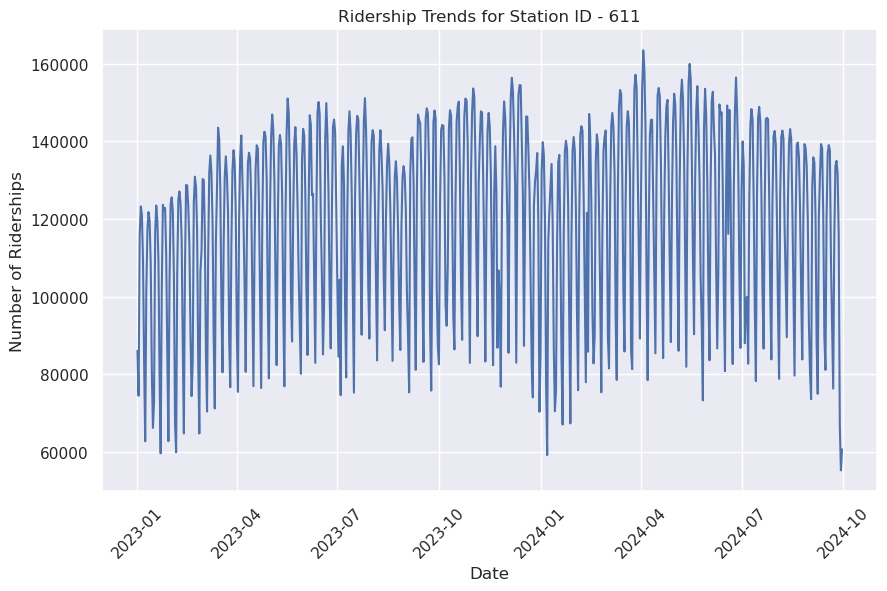

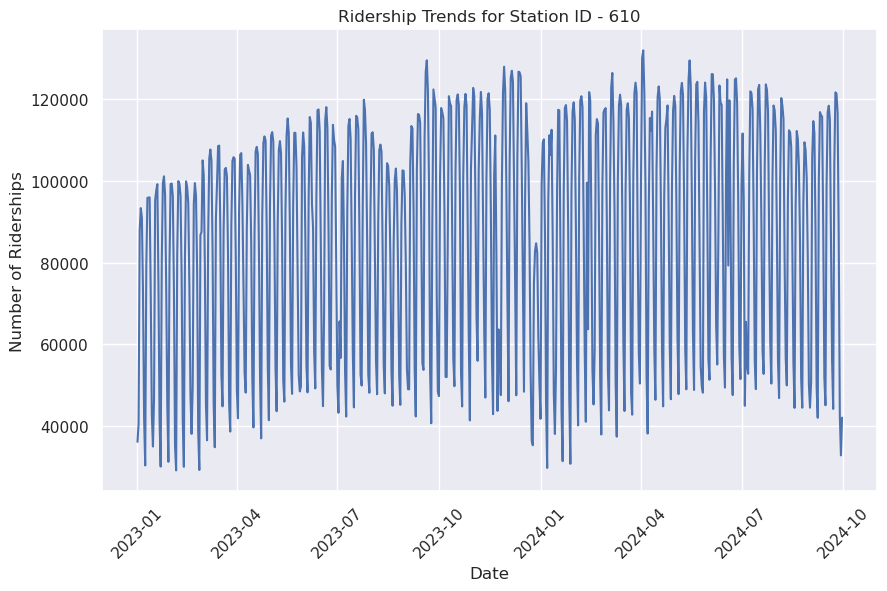

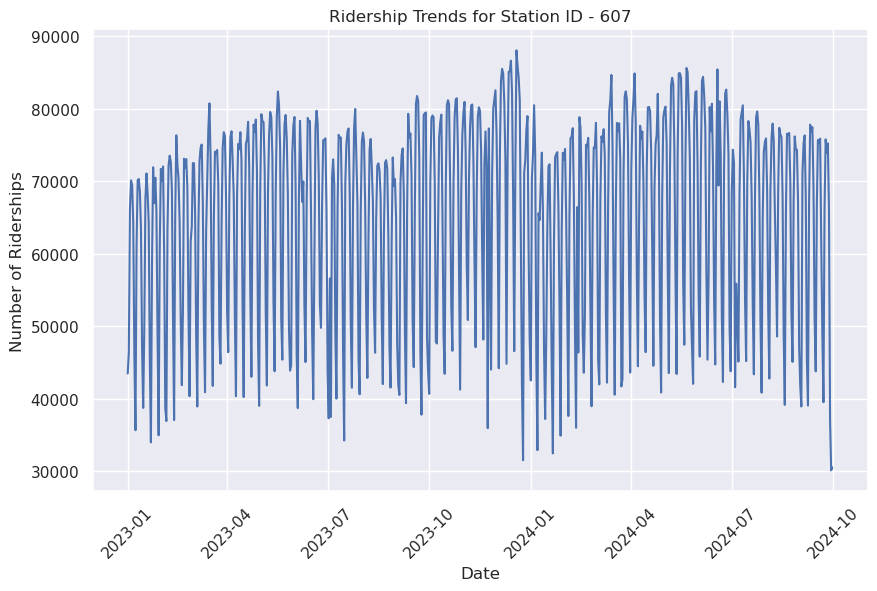

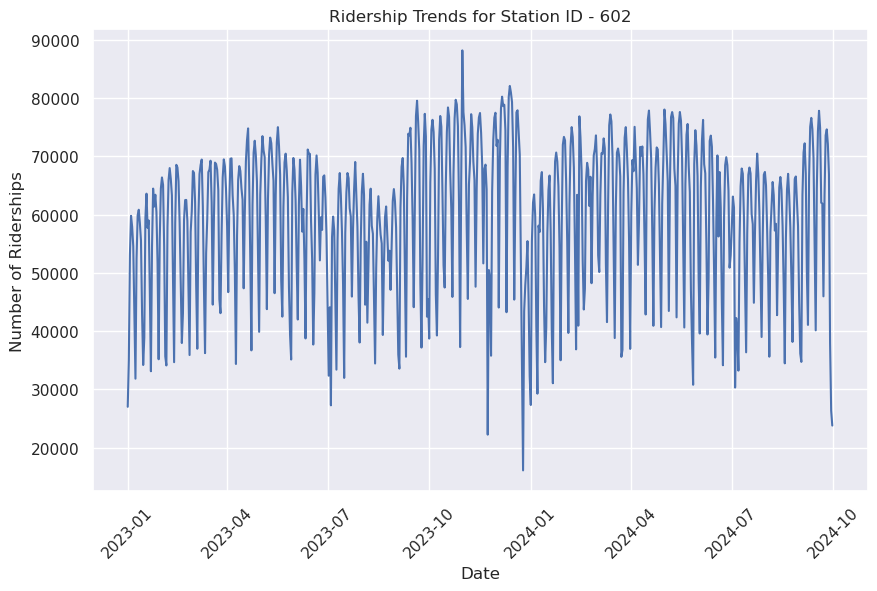

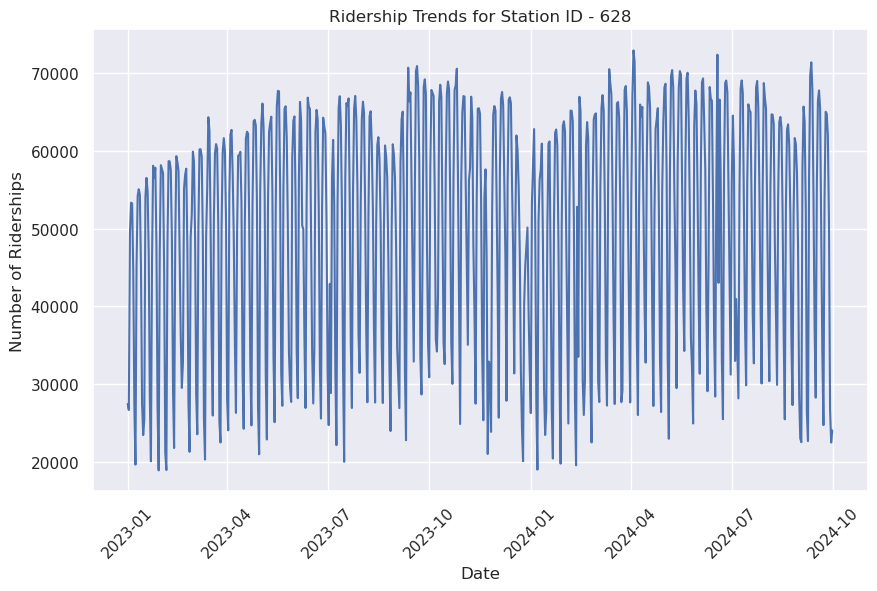

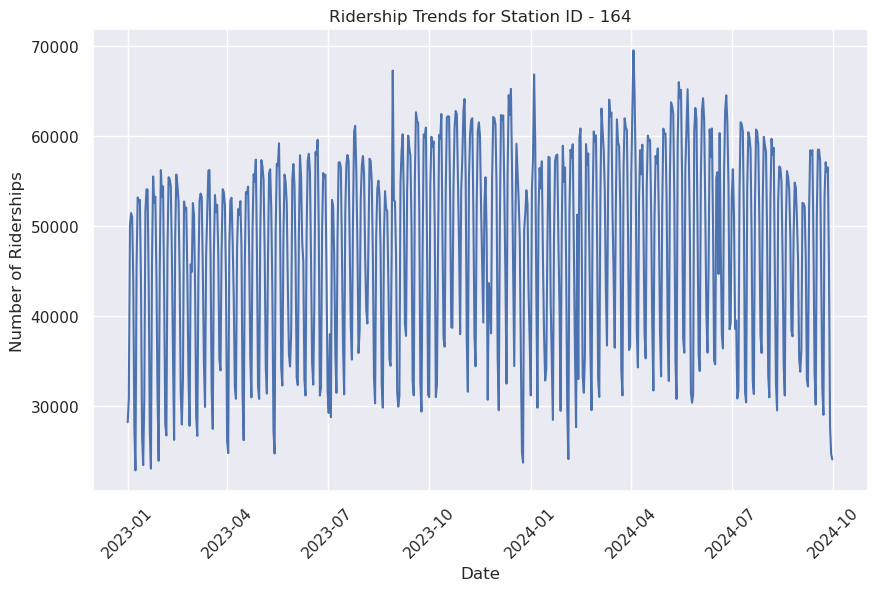

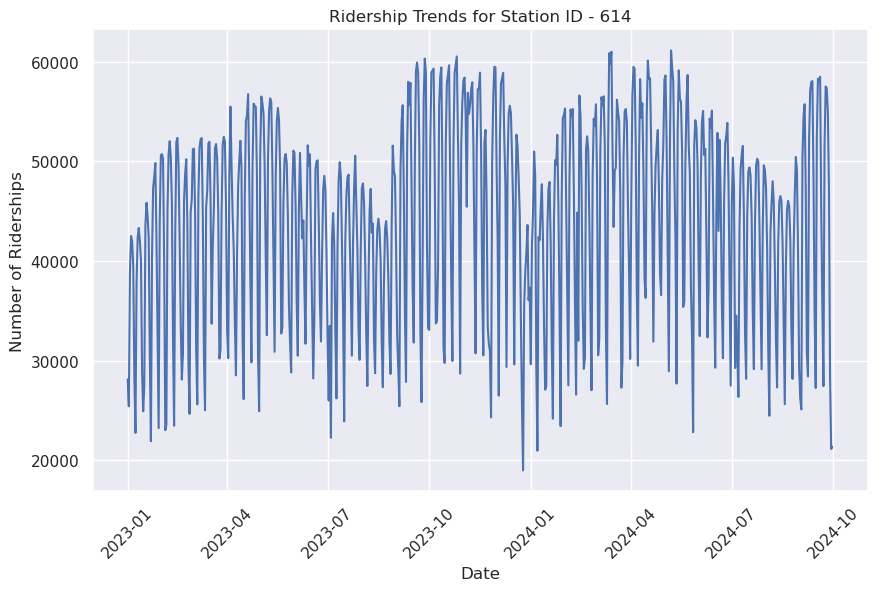

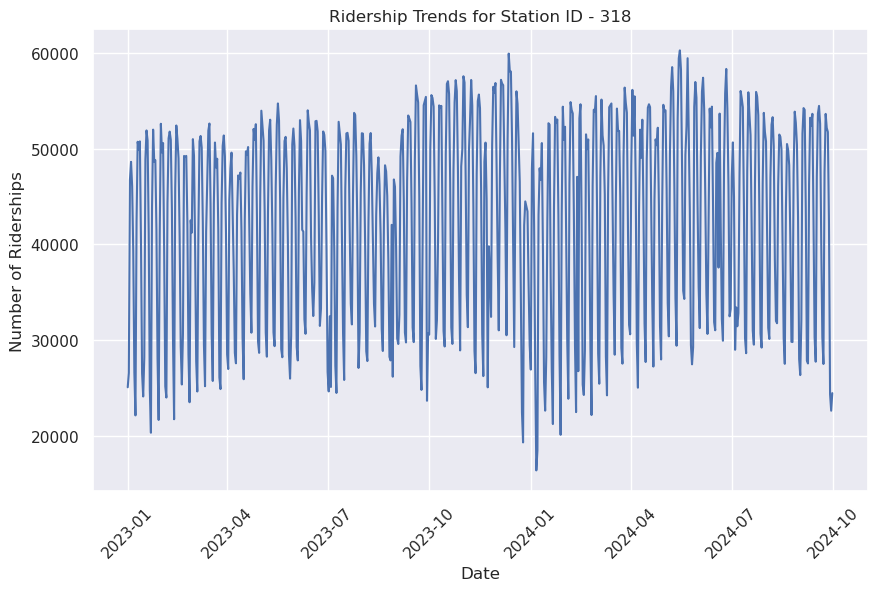

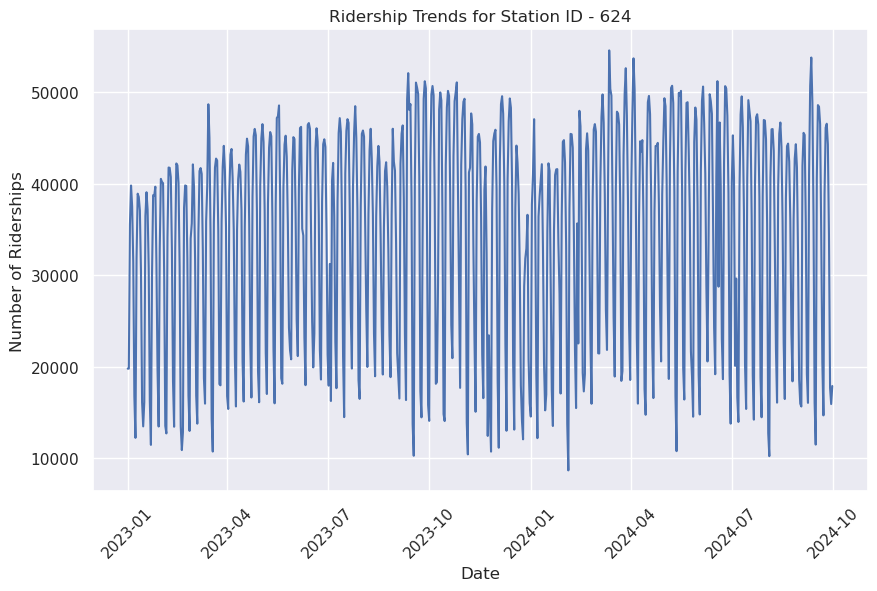

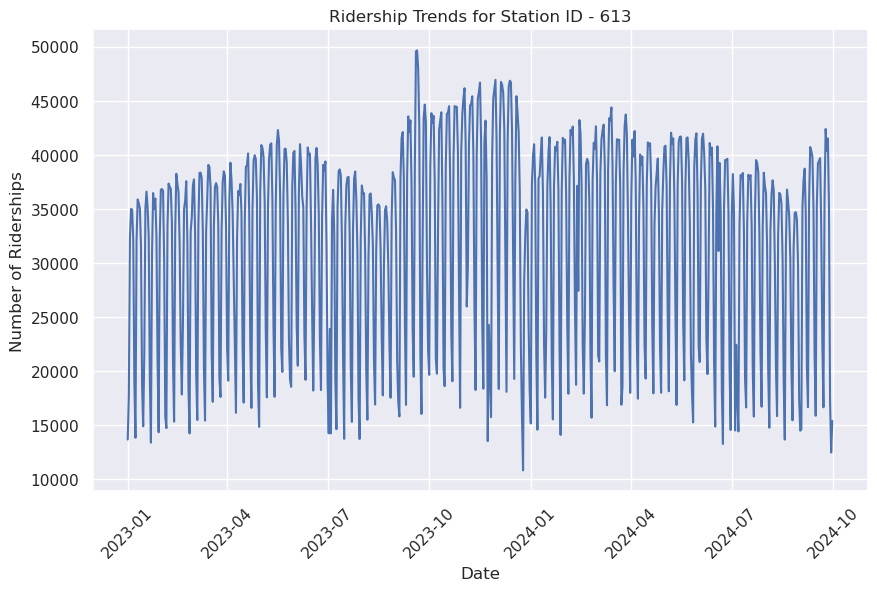

In [8]:
mta_subway_filtered = mta_subway_df[mta_subway_df.station_complex_id.isin(stations_top_10_id)]

for id_number in stations_top_10_id:
    
    data_filtered = mta_subway_filtered[mta_subway_filtered.station_complex_id == id_number]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='created_date', y='number_of_riderships', data=data_filtered)
    plt.title(f'Ridership Trends for Station ID - {id_number}')
    plt.xlabel('Date')
    plt.ylabel('Number of Riderships')
    plt.xticks(rotation=45)


- Here we can see that the data has seasonal variations hence we have to use SARIMA

- Autocorrelation Plot

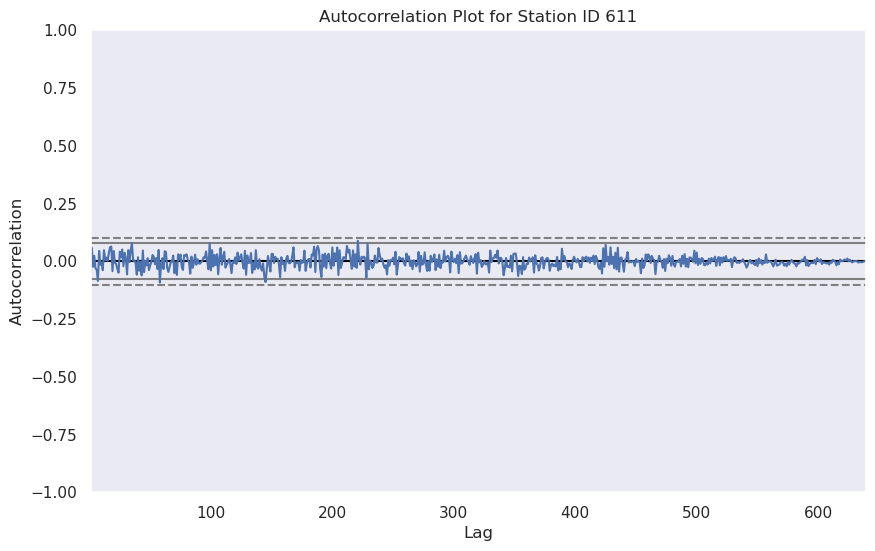

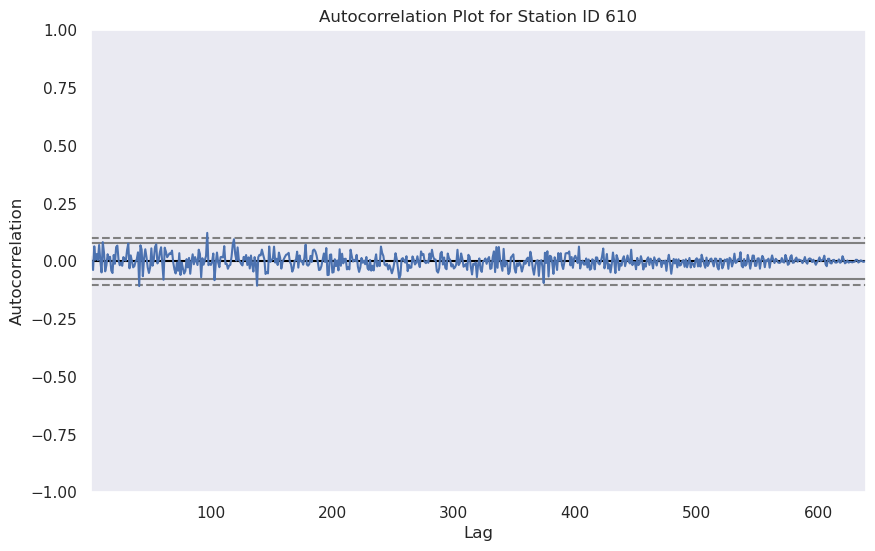

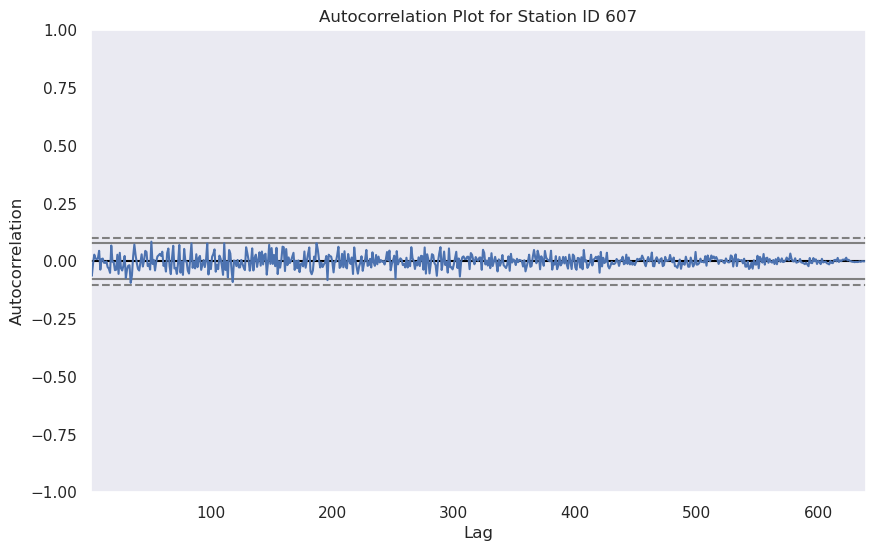

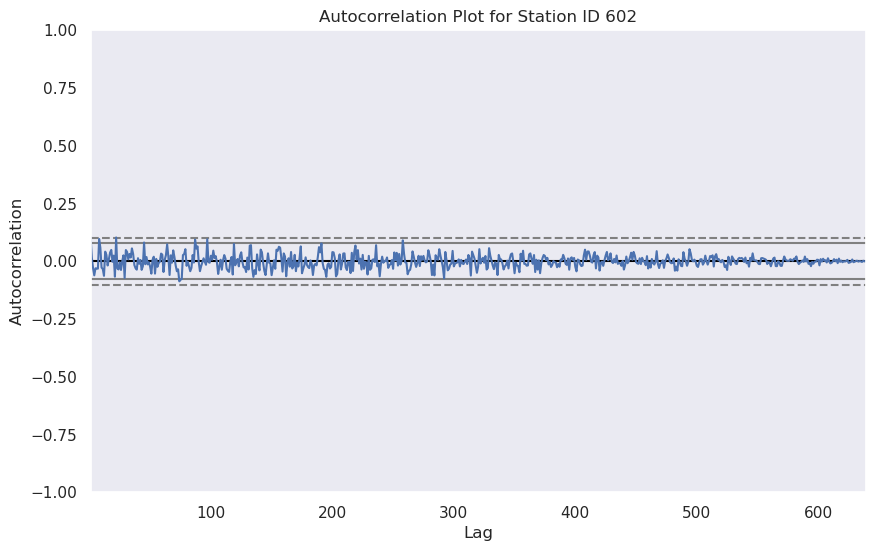

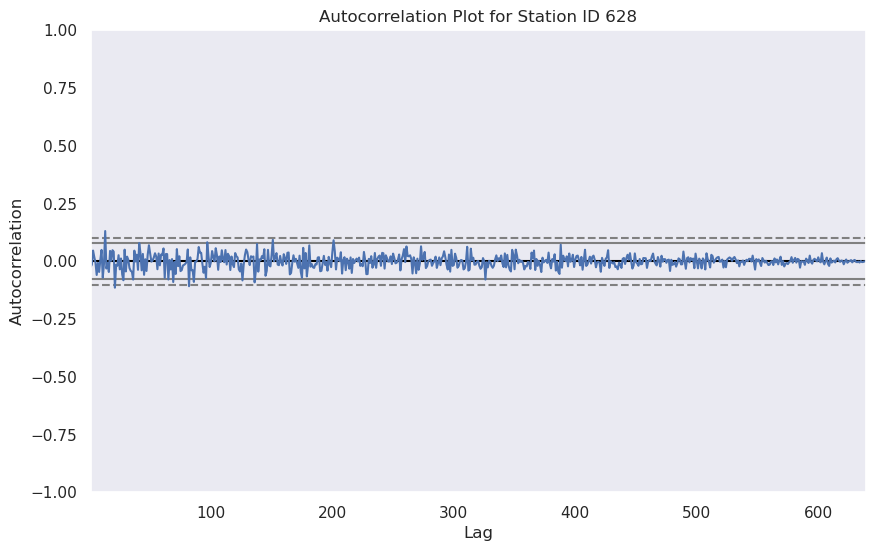

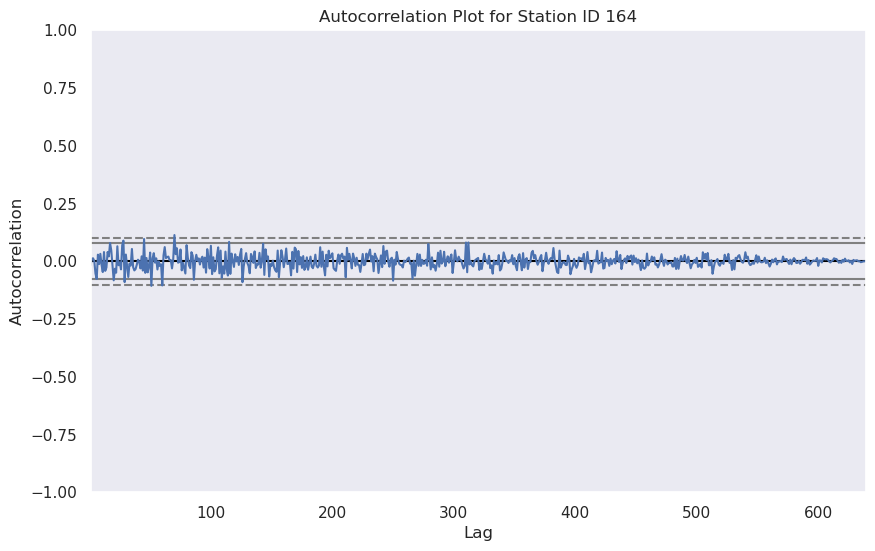

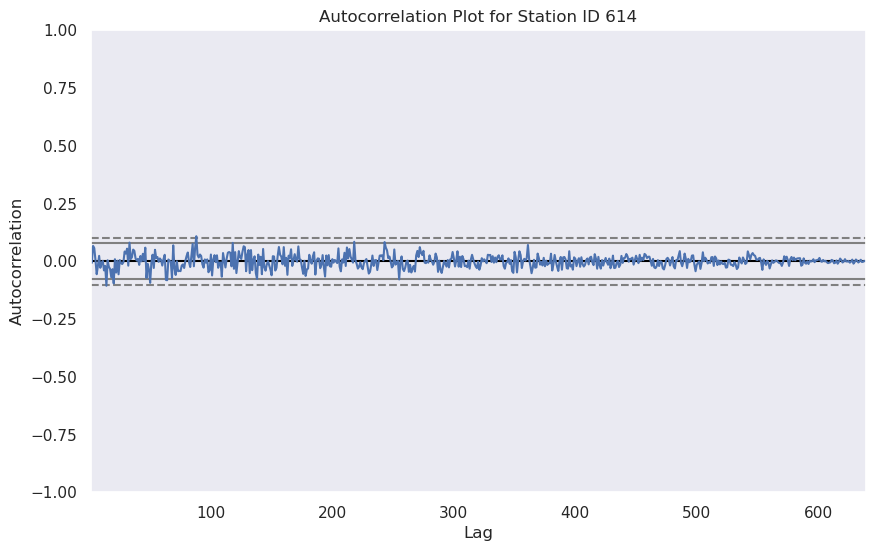

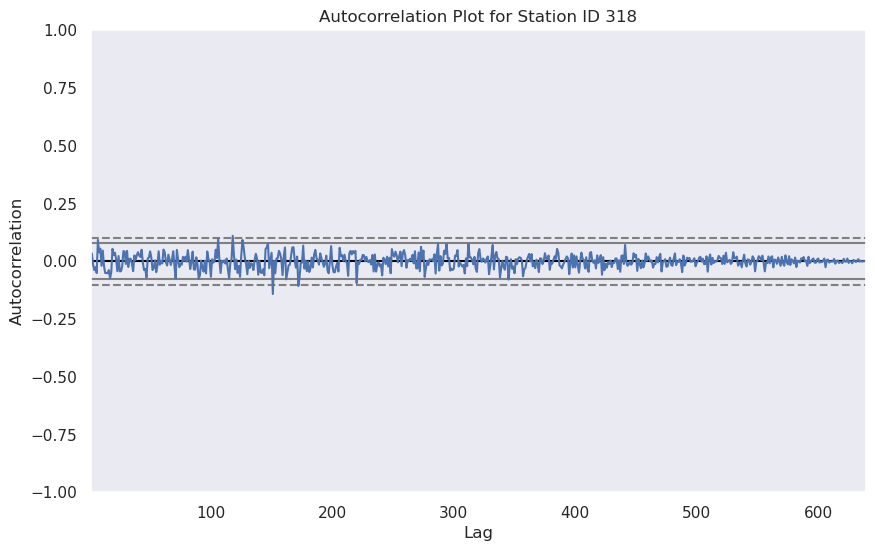

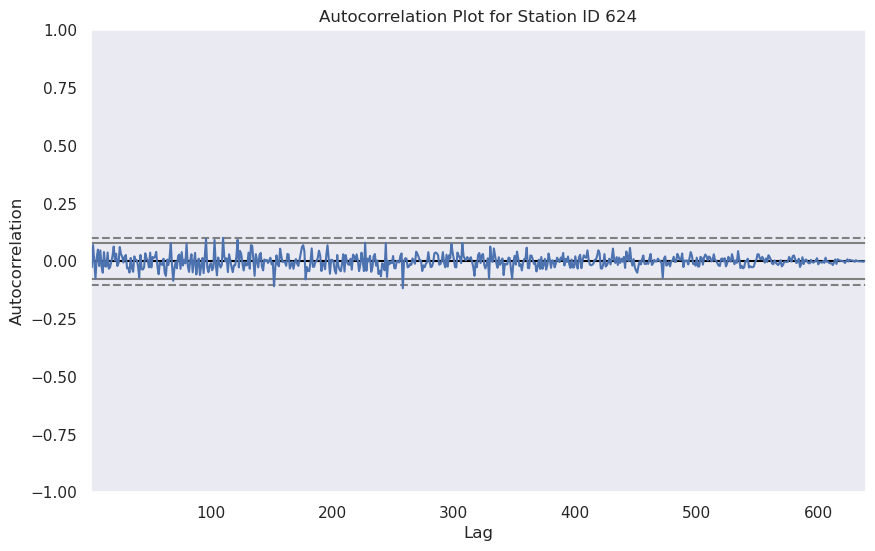

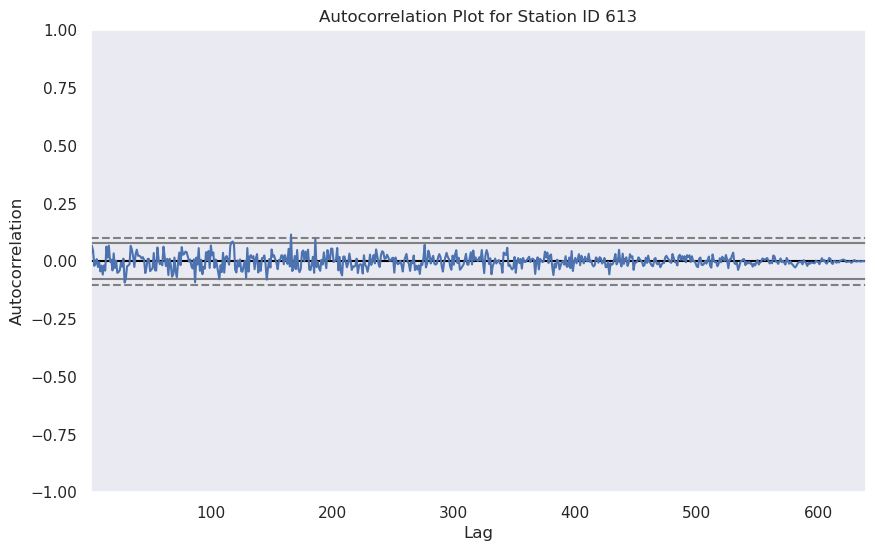

In [9]:
for id_number in stations_top_10_id:
    data_filtered = mta_subway_filtered[mta_subway_filtered.station_complex_id == id_number]

    plt.figure(figsize=(10, 6))
    autocorrelation_plot(data_filtered['number_of_riderships'])
    plt.title(f'Autocorrelation Plot for Station ID {id_number}')

- Autocorrelation

<Figure size 1000x600 with 0 Axes>

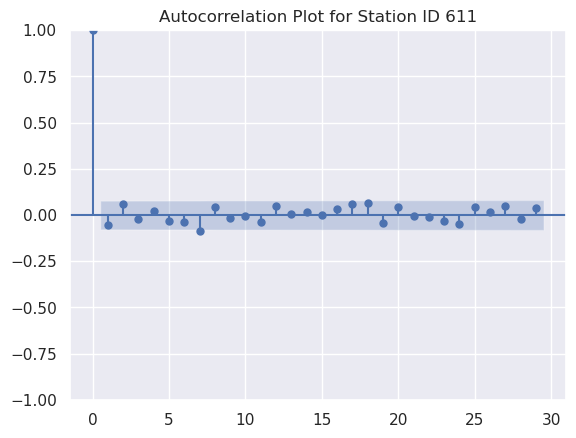

<Figure size 1000x600 with 0 Axes>

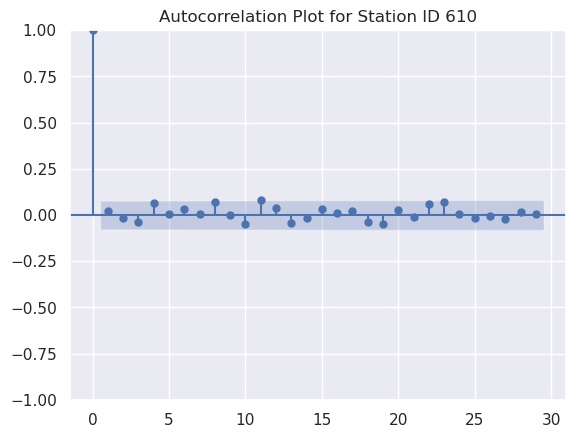

<Figure size 1000x600 with 0 Axes>

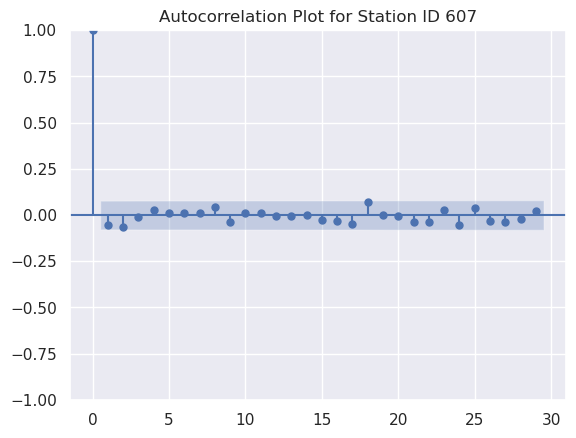

<Figure size 1000x600 with 0 Axes>

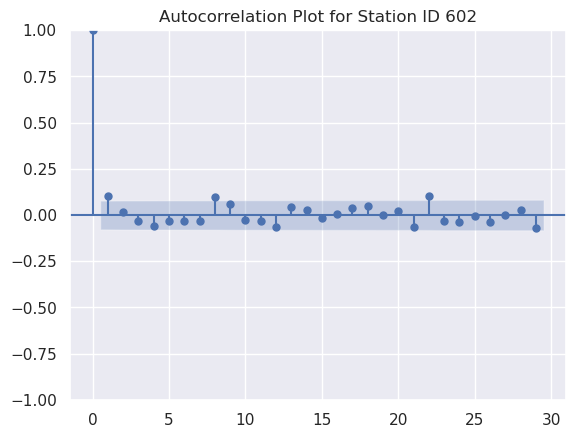

<Figure size 1000x600 with 0 Axes>

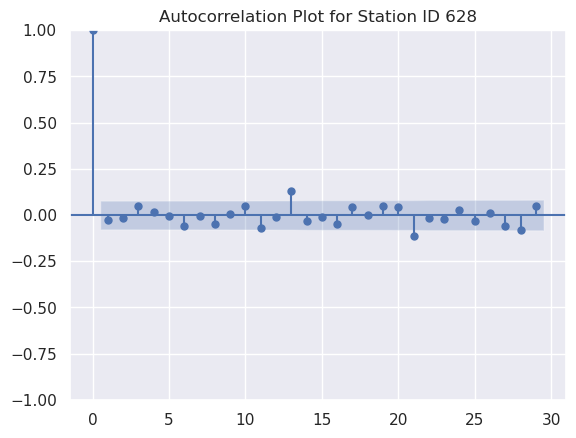

<Figure size 1000x600 with 0 Axes>

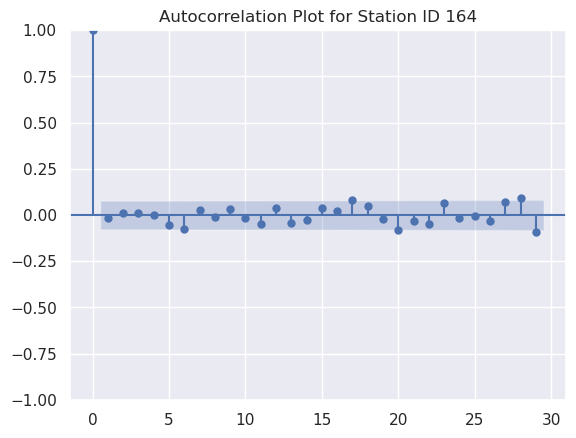

<Figure size 1000x600 with 0 Axes>

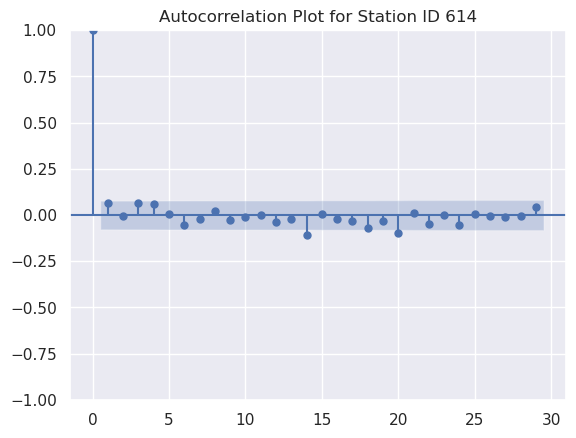

<Figure size 1000x600 with 0 Axes>

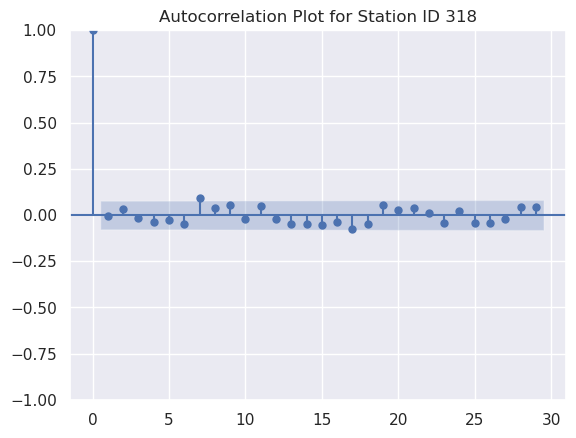

<Figure size 1000x600 with 0 Axes>

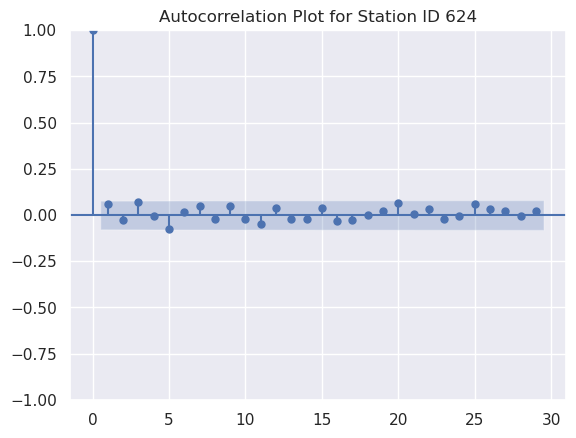

<Figure size 1000x600 with 0 Axes>

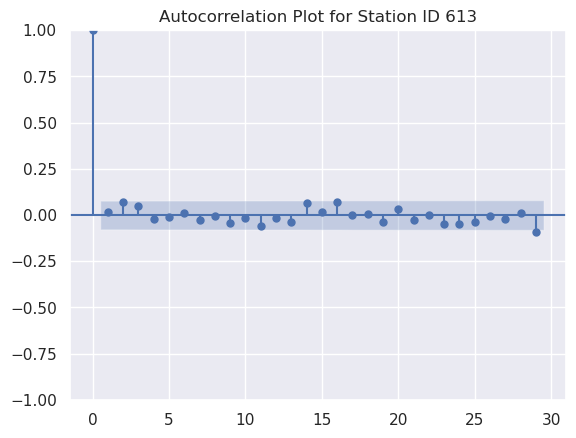

In [10]:
for id_number in stations_top_10_id:
    data_filtered = mta_subway_filtered[mta_subway_filtered.station_complex_id == id_number]

    plt.figure(figsize=(10, 6))
    plot_acf(data_filtered['number_of_riderships'])
    plt.title(f'Autocorrelation Plot for Station ID {id_number}')

- Autocorrelation Partial

<Figure size 1000x600 with 0 Axes>

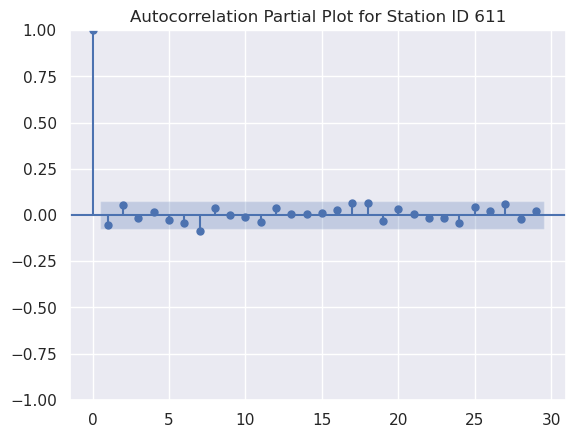

<Figure size 1000x600 with 0 Axes>

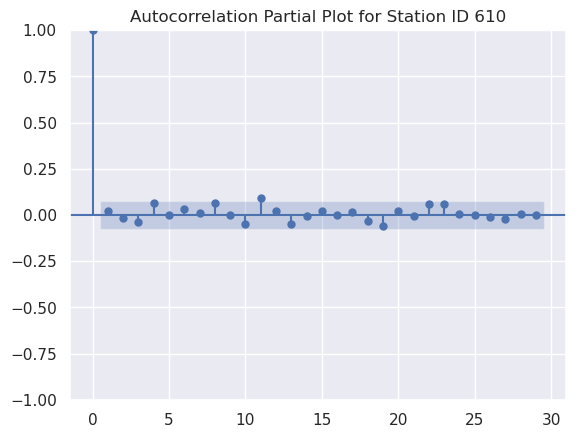

<Figure size 1000x600 with 0 Axes>

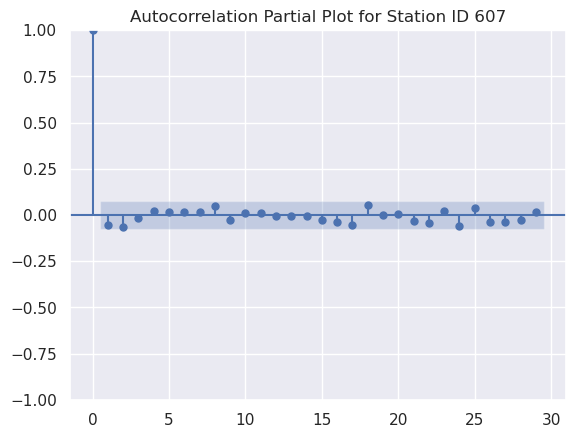

<Figure size 1000x600 with 0 Axes>

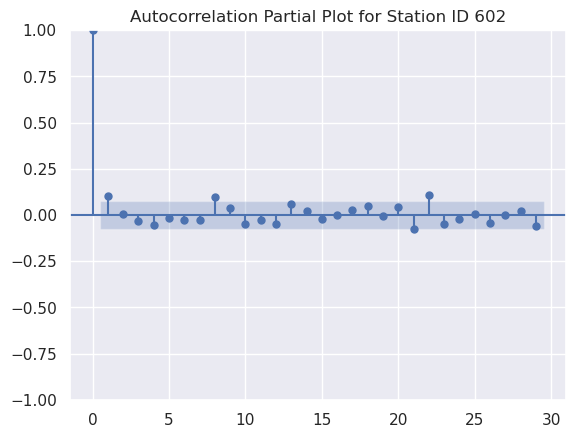

<Figure size 1000x600 with 0 Axes>

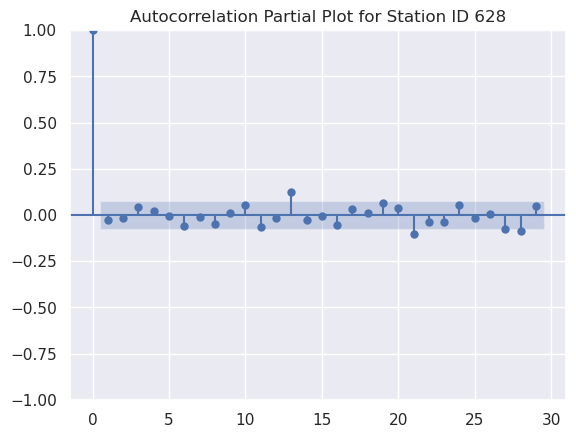

<Figure size 1000x600 with 0 Axes>

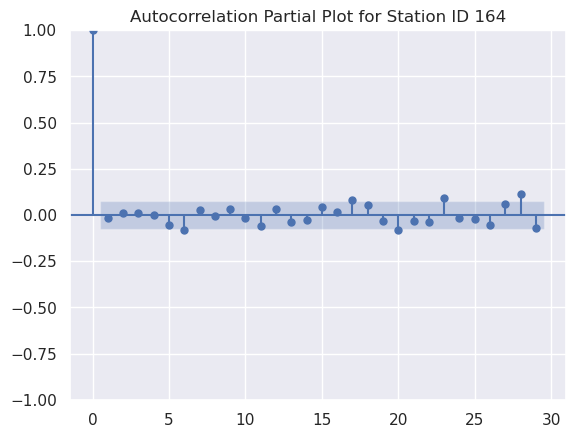

<Figure size 1000x600 with 0 Axes>

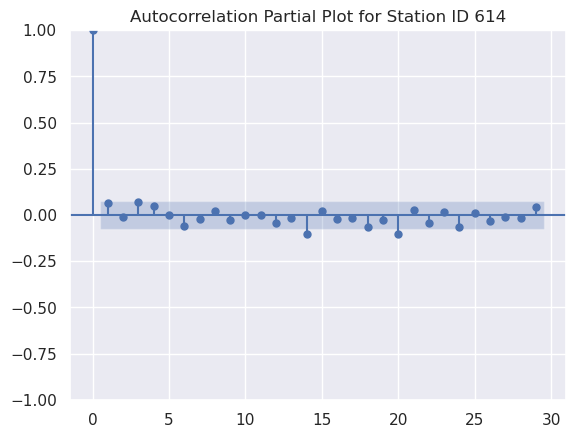

<Figure size 1000x600 with 0 Axes>

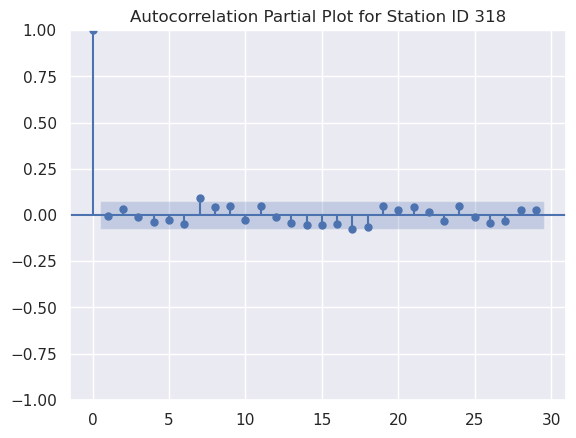

<Figure size 1000x600 with 0 Axes>

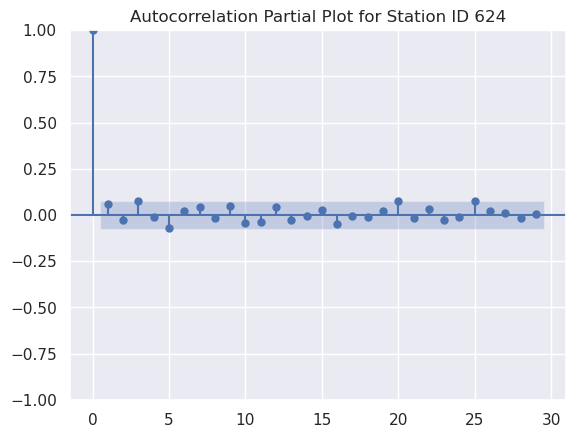

<Figure size 1000x600 with 0 Axes>

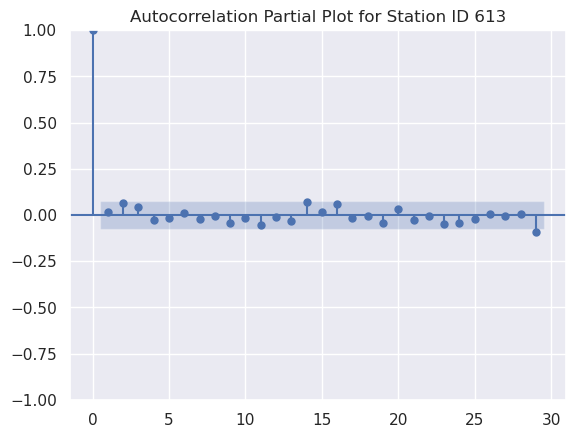

In [11]:
for id_number in stations_top_10_id:
    data_filtered = mta_subway_filtered[mta_subway_filtered.station_complex_id == id_number]

    plt.figure(figsize=(10, 6))
    plot_pacf(data_filtered['number_of_riderships'])
    plt.title(f'Autocorrelation Partial Plot for Station ID {id_number}')

- Seasonal Decomposition

<Figure size 1000x600 with 0 Axes>

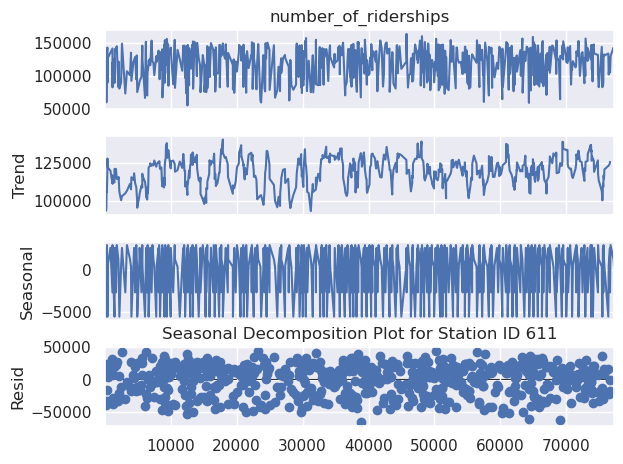

<Figure size 1000x600 with 0 Axes>

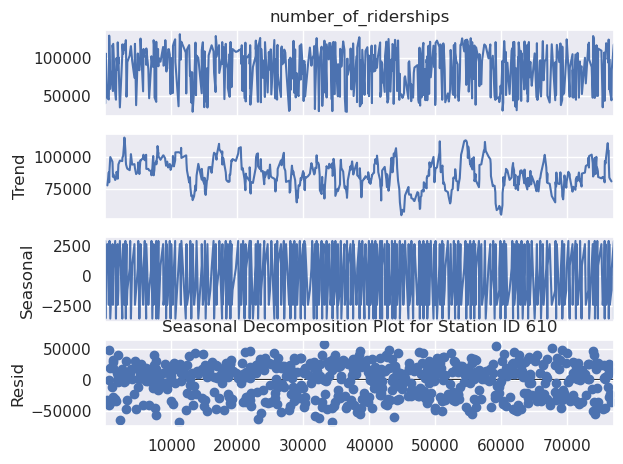

<Figure size 1000x600 with 0 Axes>

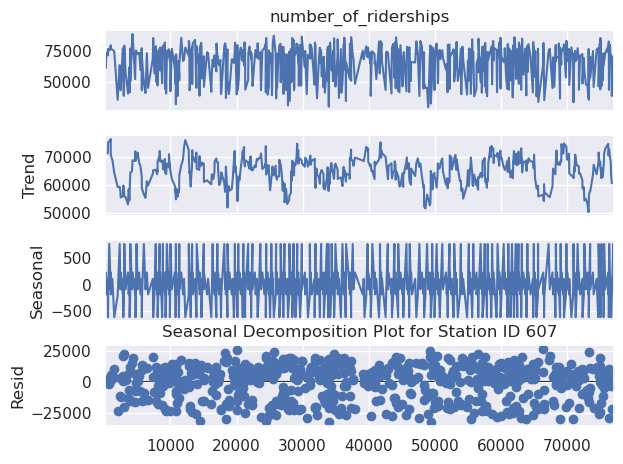

<Figure size 1000x600 with 0 Axes>

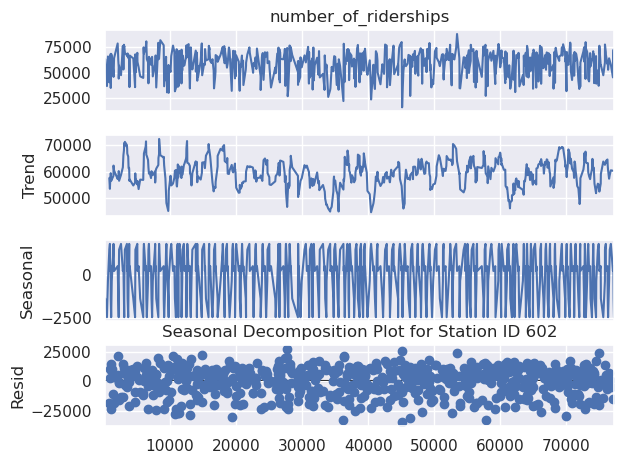

<Figure size 1000x600 with 0 Axes>

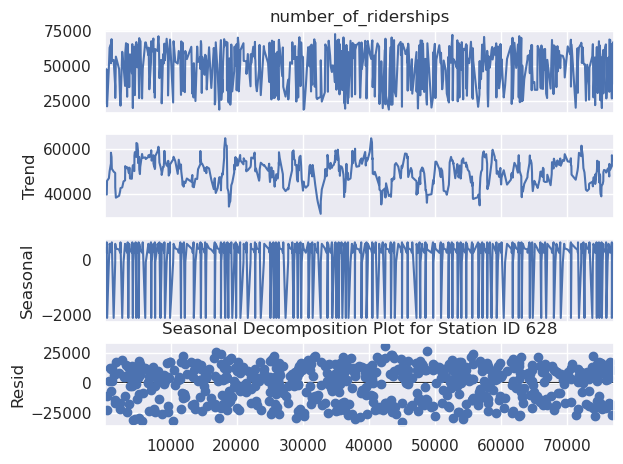

<Figure size 1000x600 with 0 Axes>

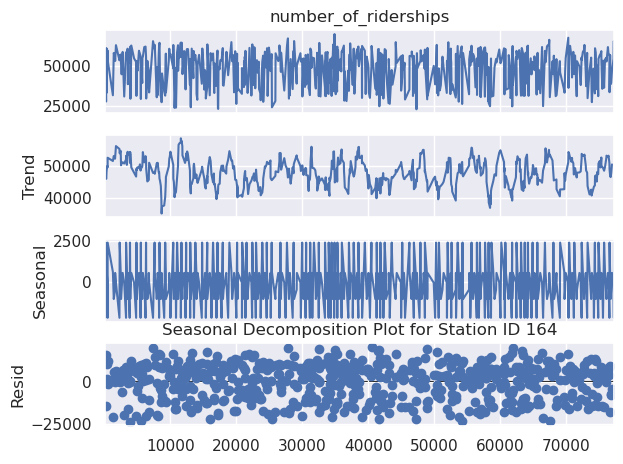

<Figure size 1000x600 with 0 Axes>

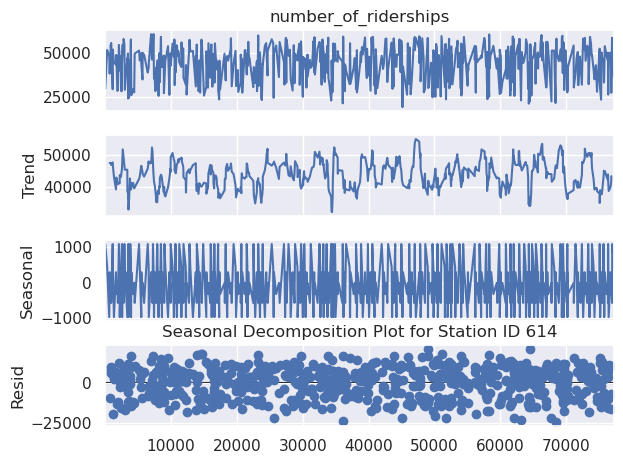

<Figure size 1000x600 with 0 Axes>

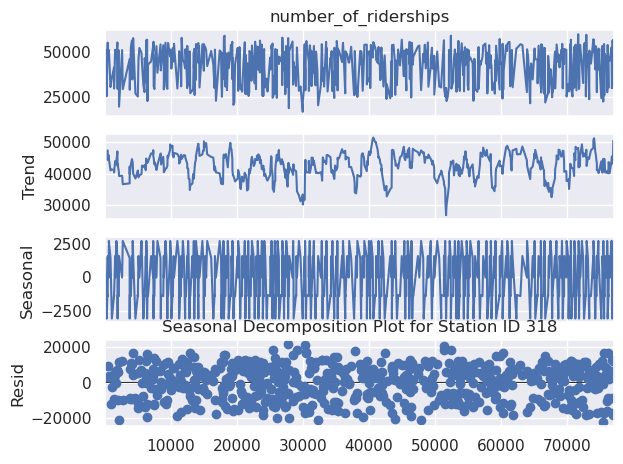

<Figure size 1000x600 with 0 Axes>

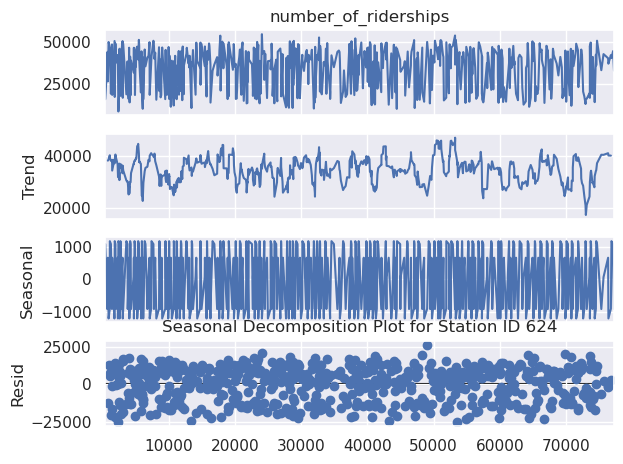

<Figure size 1000x600 with 0 Axes>

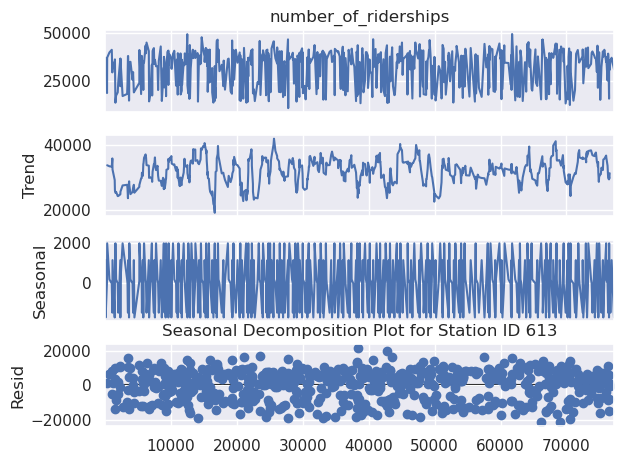

In [12]:
for id_number in stations_top_10_id:
    data_filtered = mta_subway_filtered[mta_subway_filtered.station_complex_id == id_number]

    plt.figure(figsize=(10, 6))
    decomposition=seasonal_decompose(data_filtered['number_of_riderships'], model='additive', period=7)
    decomposition.plot()
    plt.title(f'Seasonal Decomposition Plot for Station ID {id_number}')

- Stationary  Test

In [13]:
for id_number in stations_top_10_id:
    data_filtered = mta_subway_filtered[mta_subway_filtered.station_complex_id == id_number]
    dftest = adfuller(data_filtered.number_of_riderships, autolag = 'AIC')
    print(f"1. ADF - Station ID - {id_number}: ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    print("---------------------------------------------------------------------------------------")

1. ADF - Station ID - 611:  -26.556335462299646
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 638
5. Critical Values :
	 1% :  -3.440641231176813
	 5% :  -2.8660808067889976
	 10% :  -2.569188186240308
---------------------------------------------------------------------------------------
1. ADF - Station ID - 610:  -24.747357427116857
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 638
5. Critical Values :
	 1% :  -3.440641231176813
	 5% :  -2.8660808067889976
	 10% :  -2.569188186240308
---------------------------------------------------------------------------------------
1. ADF - Station ID - 607:  -19.537157571880783
2. P-Value :  0.0
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 637
5. Critical Values :
	 1% :  -3.44065745275905
	 5% :  -2.8660879520543534
	 10% :  -2.5691919933016076

## Save Constants

In [40]:
file_name = "constants.py"

with open(file_name, "w") as file:
    file.write("# File with constants\n")
    file.write(f"TOP_20_STATIONS_ID = {stations_top_20_id}\n")